# Storing each 50ms row as a seperate spectrum
50 ms row = 1102 samples

13 rows = 650ms

In [1]:
import scipy
import scipy.signal
import numpy as np
import librosa
import librosa.display
from scipy.io import wavfile
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 4.0)

In [2]:
def restore(D, frame_size, hop_length, epochs=100, window='hann'):
    
    D = np.concatenate((np.zeros((D.shape[0], 1)), D, np.zeros((D.shape[0], 1))), axis=1)
    mag, _ = librosa.magphase(D)
    #mag = np.abs(D)
    
    phase = np.exp(1.j * np.random.uniform(0., 2*np.pi, size=mag.shape))
    x_ = librosa.istft(mag * phase, hop_length=hop_length, center=False, window=window)
    
    for i in range(epochs):
        _, phase = librosa.magphase(librosa.stft(x_, n_fft=frame_size, hop_length=hop_length, center=False,
                                                 window=window))
        x_ = librosa.istft(mag * phase, hop_length=hop_length, center=False, window=window)
        
    return x_[hop_length:-hop_length]

In [3]:
def plot_spectrogram(S, sr, hop_length, y_axis='linear'):
    plt.figure(figsize=(25, 10))
    S = librosa.power_to_db(S)
    librosa.display.specshow(S, sr=sr, hop_length=hop_length, x_axis='time', y_axis=y_axis)
    plt.colorbar()

### Loading Sounds

In [4]:
names = ['Ba.wav', 'fa.wav', 'Ga.wav', 'Ma.wav', 'Ra.wav', 'Bu.wav', 'Ru.wav', 'mu.wav', 'fu.wav', 'Gu.wav']
path = '/home/srg/Documents/MSU/EEG/data/sound_files/'
SR = 22050

Sounds = []
for name in names:
    Sounds.append(librosa.load(path + name, sr=SR)[0])

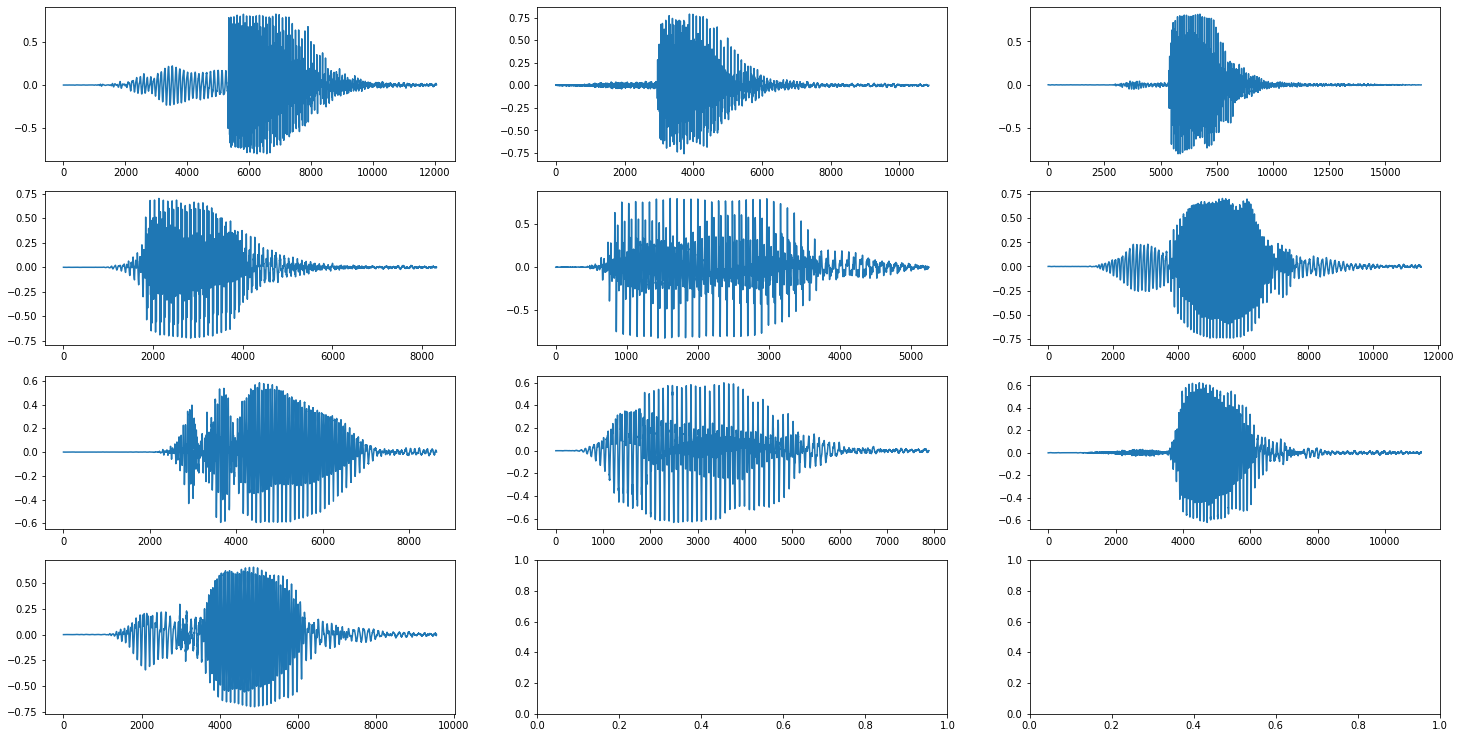

In [125]:
fig, axes = plt.subplots(figsize=(25, 13), nrows=4, ncols=3)
for i in range(4):
    for j in range(3):
        axes[i][j].plot(Sounds[3 * i + j])
        if 3 * i + j == 9:
            break

### Reshaping to 300 ms

In [11]:
Snd = np.empty((0, 6766))
Snd = np.append(Snd, Sounds[0][3000:9766].reshape(1, -1), axis=0)
Snd = np.append(Snd, Sounds[1][1000:7766].reshape(1, -1), axis=0)
Snd = np.append(Snd, Sounds[2][4000:10766].reshape(1, -1), axis=0)
Snd = np.append(Snd, Sounds[3][:6766].reshape(1, -1), axis=0)
tmp = Sounds[4][:-1]
tmp = np.pad(tmp, ((6766 - tmp.shape[0]) // 2,
                           (6766 - tmp.shape[0]) // 2), 'constant', constant_values=(0, 0))
Snd = np.append(Snd, tmp.reshape(1, -1), axis=0)
Snd = np.append(Snd, Sounds[5][2200:8966].reshape(1, -1), axis=0)
Snd = np.append(Snd, Sounds[6][-6766:].reshape(1, -1), axis=0)
Snd = np.append(Snd, Sounds[7][250:7016].reshape(1, -1), axis=0)
Snd = np.append(Snd, Sounds[8][2000:8766].reshape(1, -1), axis=0)
Snd = np.append(Snd, Sounds[9][1300:8066].reshape(1, -1), axis=0)

In [12]:
Snd.shape

(10, 6766)

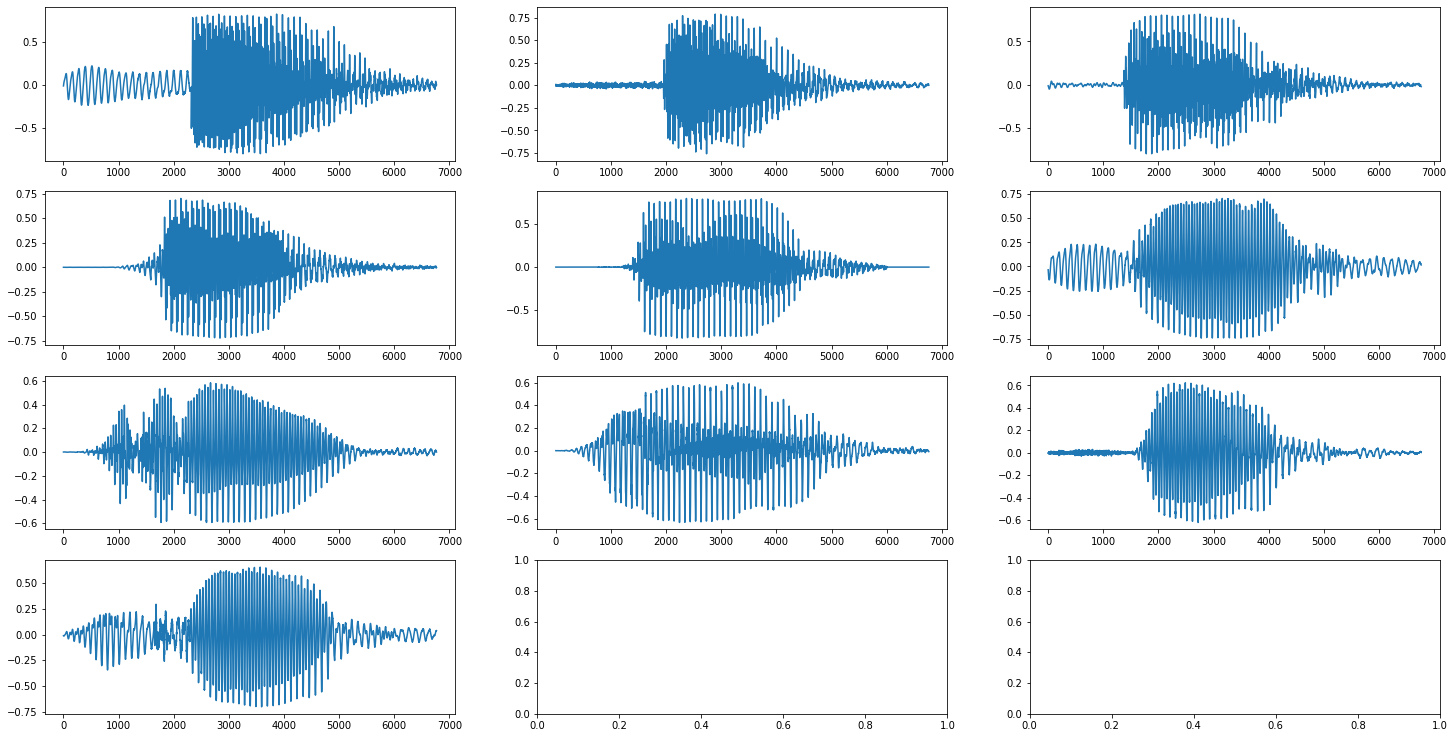

In [13]:
fig, axes = plt.subplots(figsize=(25, 13), nrows=4, ncols=3)
for i, snd in enumerate(Snd):
    axes[i // 3][i % 3].plot(snd)

In [51]:
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/2.wav', SR, np.squeeze(Snd.reshape(-1, 1)))

# Computing spectrums

In [9]:
FRAME_SIZE = 512
SR = 22050
HOP_LENGTH = 118

    6 rows = 4642 samples
    8 rows = 6058 samples
    9 rows = 6766 samples

##### Contiguous slice

In [14]:
sounds = np.squeeze(Snd.reshape(-1, 1))
sounds.shape

(67660,)

In [15]:
# Whole sound -> spectrum

spec = np.abs(librosa.stft(sounds, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, center=False))
spec.shape

(257, 570)

##### Single syllable -> spectrum

In [53]:
# with some space in-between

sounds = np.empty((0, 6766))
for sound in Snd.reshape(10, -1):
    sounds = np.append(sounds, np.zeros((5, 6766)))
    sounds = np.append(sounds, sound.reshape(1, -1))

In [49]:
spec = np.empty((257, 0))
for snd in Snd.reshape(10, -1):
    x = np.abs(librosa.stft(snd, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, center=False))
    spec = np.append(spec, x, axis=1)
spec.shape

(257, 540)

In [17]:
x_ = restore(spec, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=30)
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/2.wav', SR, x_)

### A, B matrices

In [96]:
LEARNING_SAMPLES = 6

In [97]:
A = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/VIE_bashirinslsl_och.csv', delimiter=';', ndmin=2)
label = A[:, 0]
A = A[:, 1:]
A.shape

(25586, 36)

    11
    
    
        ..
        ..

In [98]:
all_indices = np.arange(len(label))[label > 10]
odd_indices = set(all_indices - 1).intersection(all_indices)
indices = set(all_indices) - odd_indices
indices = np.array(sorted(list(indices)))
indices

array([  178,   341,   423,   505,   750,   832,   913,   995,  1077,
        1159,  1322,  1404,  1812,  1894,  1976,  2058,  2139,  2221,
        2303,  2385,  2466,  2630,  2712,  2875,  2957,  3039,  3202,
        3284,  3366,  3447,  3529,  3611,  3774,  4101,  4346,  4428,
        4592,  4673,  4755,  4837,  4919,  5000,  5082,  5164,  5246,
        5327,  5572,  5654,  5736,  5818,  5899,  5981,  6145,  6472,
        6553,  6635,  6799,  6962,  7126,  7207,  7289,  7371,  7452,
        7534,  7698,  7779,  7861,  8025,  8106,  8188,  8270,  8352,
        8433,  8515,  8842,  8924,  9006,  9087,  9169,  9251,  9333,
        9414,  9496,  9578,  9660,  9741,  9823,  9905,  9986, 10068,
       10150, 10232, 10313, 10395, 10477, 10559, 10640, 10722, 10886,
       11131, 11213, 11294, 11376, 11458, 11540, 11621, 11703, 11785,
       11866, 11948, 12030, 12112, 12193, 12275, 12357, 12520, 12602,
       12766, 12847, 12929, 13093, 13174, 13256, 13501, 13583, 13665,
       13746, 13828,

In [99]:
# Test on 13

indices11 = indices[label[indices] == 11]
indices11 += 3 # or + 4
indices11 = np.array(sorted(list(set(indices11).union(*[set(indices11 + j) for j in range(1, 9)]))))
label[indices11]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

    13
        ..
        ..
        ..
        ..
    3
        ..
        ..
        ..
        ..

##### A

In [100]:
A[indices11[:9*LEARNING_SAMPLES]].shape

(54, 36)

##### B

In [101]:
spec11 = spec[:, :54].T
spec11 = spec11.reshape(9, 6, 257).reshape(9, 257*6)

B = np.empty((0, 257*6))
for i in range(LEARNING_SAMPLES):
    B = np.append(B, spec11, axis=0)
B.shape

(54, 1542)

In [130]:
# 13 in between

def get_nearest(label, ind):
    while label[ind] != 0:
        ind += 1
    return ind - 1

restricted_mode = False 
rest_num = 1
rest_arr = np.zeros(10)
indices1 = np.empty(0)
indices2 = np.empty(0)
hops = 12 # zeroes
flag = 0 # in block 
count = 0

for i, val in enumerate(label):
    if val == 0:
        if flag:
            count += 1
            continue
        else:
            continue
    
    if val > 10:
        if restricted_mode & (rest_arr[int(val) % 10] == rest_num):
            continue
        count = 0
        flag = 1
        last_ind = i
    else:
        if count != hops:
            count = 0
            continue
        else: 
            count = 0
            flag = 0
            rest_arr[int(val) % 10] += 1
            indices1 = np.append(indices1, last_ind)
            indices2 = np.append(indices2, get_nearest(label, i))
            
indices1 = np.array(sorted(list(set(indices1).union(*[set(indices1 + j) for j in range(1, 13)]))))
indices2 = np.array(sorted(list(set(indices2).union(*[set(indices2 + j) for j in range(1, 13)]))))
inds = np.array(sorted(list(set(indices1).union(indices2)))).astype(int)
label[inds][::13]

array([18.,  8., 13.,  3., 13.,  3., 14.,  4., 19.,  9., 20., 10., 19.,
        9., 16.,  6., 18.,  8., 18.,  8., 19.,  9., 17.,  7., 15.,  5.,
       11.,  1., 13.,  3., 11.,  1., 11.,  1., 15.,  5., 14.,  4., 17.,
        7., 17.,  7., 15.,  5., 17.,  7., 19.,  9., 18.,  8., 12.,  2.,
       20., 10., 16.,  6., 20., 10., 12.,  2., 16.,  6., 18.,  8., 14.,
        4., 20., 10., 15.,  5., 16.,  6., 12.,  2., 18.,  8., 11.,  1.,
       11.,  1., 15.,  5., 16.,  6., 15.,  5., 11.,  1., 17.,  7., 11.,
        1., 19.,  9., 20., 10., 15.,  5., 11.,  1., 13.,  3., 20., 10.,
       20., 10., 20., 10., 18.,  8., 17.,  7., 12.,  2., 19.,  9., 16.,
        6., 15.,  5., 20., 10., 17.,  7., 11.,  1., 15.,  5., 14.,  4.,
       14.,  4., 20., 10., 20., 10., 11.,  1., 18.,  8., 16.,  6., 20.,
       10., 19.,  9., 14.,  4., 11.,  1., 17.,  7., 15.,  5., 11.,  1.,
       14.,  4., 18.,  8., 20., 10., 12.,  2., 16.,  6., 14.,  4., 12.,
        2., 13.,  3., 15.,  5., 15.,  5., 18.,  8., 13.,  3., 12

In [131]:
tmp = inds[label[inds] == 11]
tmp = np.array(sorted(list(set(tmp).union(*[set(tmp + j) for j in range(1, 13)]))))
label[tmp]

array([11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [195]:
inds = tmp[:130].astype(int)

In [196]:
B = np.empty((0, 1740))

for l in label[inds][::13]:
    B = np.append(B, Specs[int(l) % 10], axis=0)
B.shape

(130, 1740)

In [102]:
np.savetxt("/home/srg/Documents/MSU/EEG/data/50ms/A.csv", A[indices11[:9*LEARNING_SAMPLES]], delimiter=",")
np.savetxt("/home/srg/Documents/MSU/EEG/data/50ms/Ainv.csv",
           np.linalg.pinv(A[indices11[:9*LEARNING_SAMPLES]]), delimiter=",")
np.savetxt("/home/srg/Documents/MSU/EEG/data/50ms/B.csv", B, delimiter=",")

# Training X

In [103]:
Aplus = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/Ainv.csv', delimiter=',', ndmin=2)
B = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/B.csv', delimiter=',', ndmin=2)
X = np.dot(Aplus, B)
X.shape

(36, 1542)

In [104]:
Atest = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/A.csv', delimiter=',', ndmin=2)
Res = np.dot(Atest, X)

In [105]:
Res = Res.reshape(-1, 6, 257).reshape(-1, 257).T

In [106]:
x_ = restore(Res, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=30)
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/2.wav', SR, x_)

In [200]:
Signal = np.empty((0, 1102))
for spec in Res:
    x_ = restore(spec.reshape(174, 10), frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=10)
    Signal = np.append(Signal, x_.reshape(1, -1), axis=0)
x = np.squeeze(Signal.reshape(-1, 1))
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/130rows.wav', SR, x)

##### Studying spectrum

In [129]:
Specs = np.empty((0, 552))
syl = Snd[0]
for row in syl:
    x = librosa.stft(row, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, center=False, window=np.ones(1102))
    Specs = np.append(Specs, x.T, axis=0) # x is (552, 1)

_, phase = librosa.magphase(Specs)
mag = np.abs(Specs)
Specs.shape

(13, 552)

In [130]:
# plot_spectrogram(np.abs(Specs.T), sr=SR, hop_length=FRAME_SIZE, y_axis='log')

In [131]:
Signal = np.empty((0, 1102))
for i, spec in enumerate(mag):
    x_ = librosa.istft(spec.reshape(552, 1) * phase[i].reshape(552, 1), hop_length=HOP_LENGTH, center=False,
                       window=np.ones(1102))
    #Signal = np.append(Signal, x_[1:-1].reshape(1, -1), axis=0)
    Signal = np.append(Signal, x_.reshape(1, -1), axis=0)
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, np.squeeze(Signal.reshape(-1, 1)))

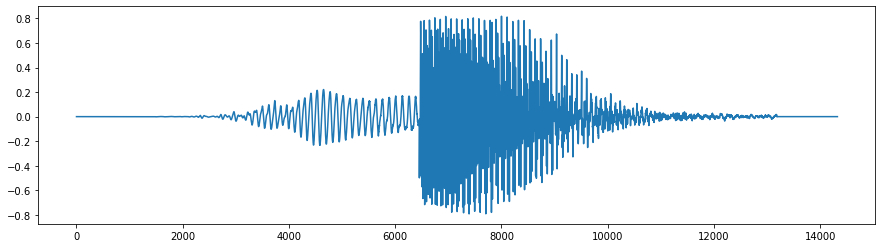

In [132]:
y = np.squeeze(Signal.reshape(-1, 1))
plt.plot(y)

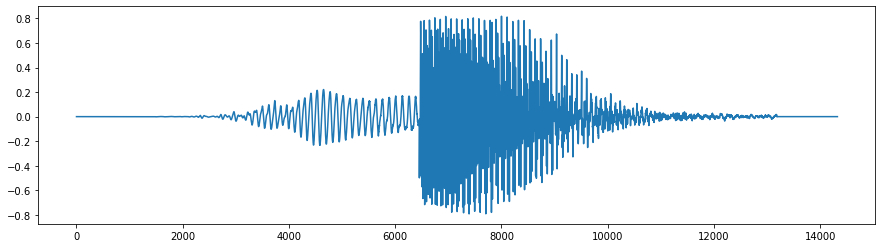

In [133]:
x = np.squeeze(Snd[0].reshape(-1, 1))
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, x)
plt.plot(x)

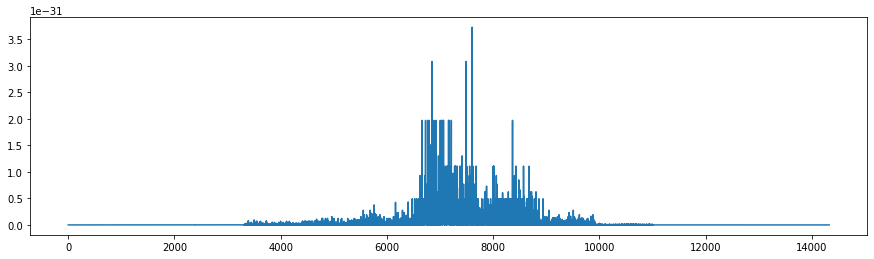

In [134]:
plt.plot((x - y) ** 2)

In [135]:
np.arange(len(x))[((x - y) ** 2) > 0.000001][:500]

array([], dtype=int64)

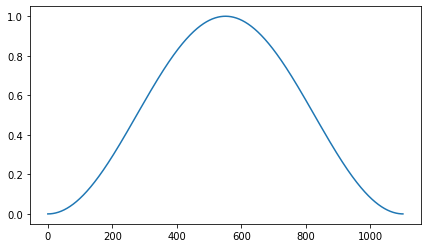

In [83]:
plt.plot(scipy.signal.hann(1102, sym=False))

### Back to sound

In [182]:
Signal = np.empty((0, 1102))
for i, spec in enumerate(Specs.reshape(130, 552)):
    x_ = restore(spec.reshape(552, 1), frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=10, window=np.ones(1102))
    #x_ = librosa.istft(spec.reshape(552, 1) * phase[i % 13].reshape(552, 1), hop_length=HOP_LENGTH, center=False, 
    #                  window=np.ones(1102))
    d = max(np.max(x_), 1)
    Signal = np.append(Signal, (x_ / d).reshape(1, -1), axis=0)
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, np.squeeze(Signal.reshape(-1, 1)))

#### Plotting restored sounds

In [183]:
cutSignal = Signal.reshape(10, -1)
cutSignal = cutSignal * (cutSignal < 1) * (cutSignal > -1)

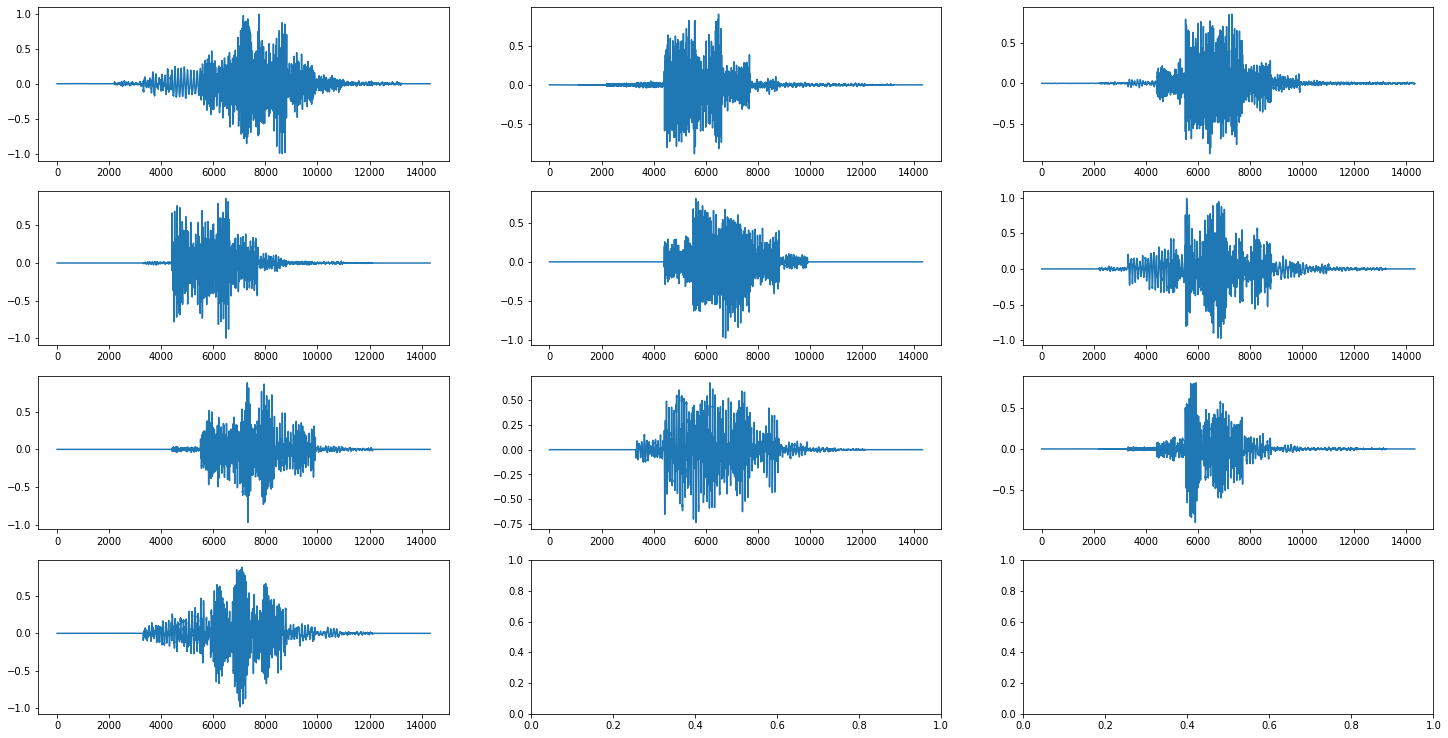

In [184]:
fig, axes = plt.subplots(figsize=(25, 13), nrows=4, ncols=3)
for i in range(4):
    for j in range(3):
        axes[i][j].plot(cutSignal[3 * i + j])
        if 3 * i + j == 9:
            break

### Analysis

#### Plotting windows for 1st syllable

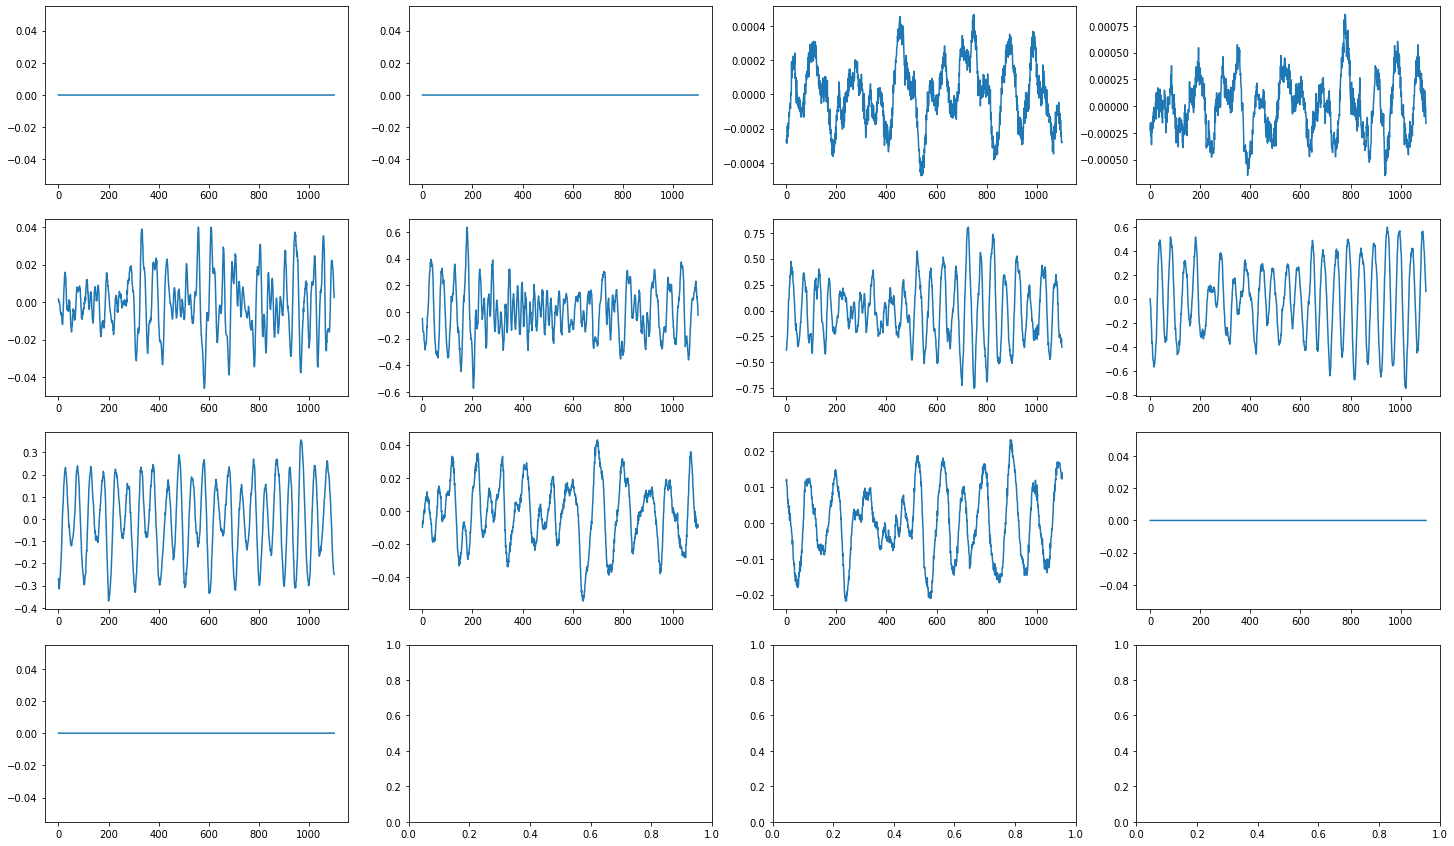

In [110]:
fig, axes = plt.subplots(figsize=(25, 15), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        axes[i][j].plot(Signal[4 * i + j])
        if 4 * i + j == 12:
            break

#### Shutting off first and last 20 samples

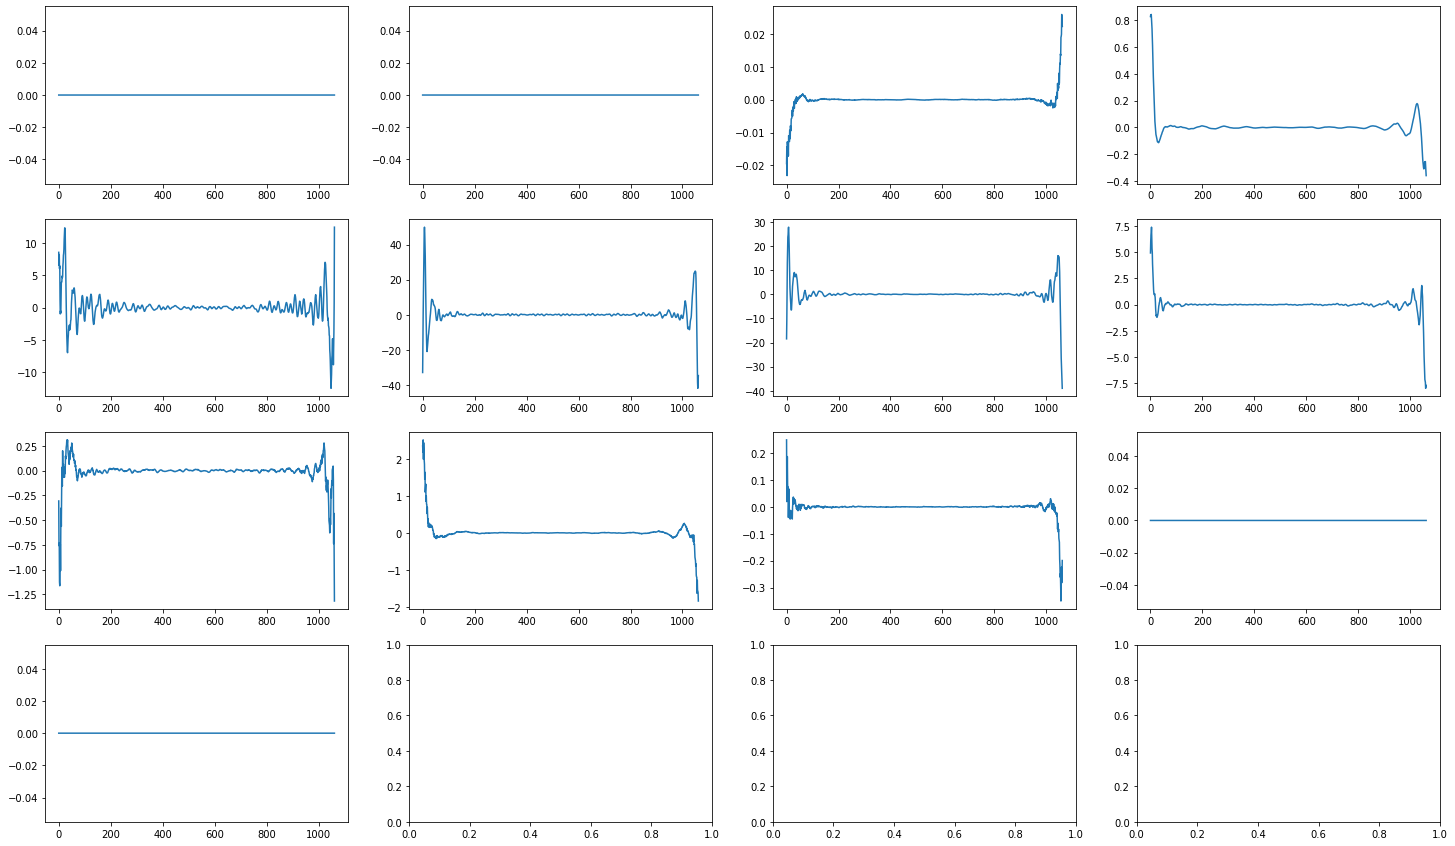

In [37]:
fig, axes = plt.subplots(figsize=(25, 15), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        axes[i][j].plot(Signal[4 * i + j][20:-20])
        if 4 * i + j == 12:
            break

In [40]:
# Saving...

save = np.empty(0)
for i in range(4):
    for j in range(4):
        save = np.append(save, Signal[4 * i + j][20:-20], axis=0)
        if 4 * i + j == 12:
            break

scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, save)
# Result: bad quality as expected

In [96]:
x = cutSignal[0][(cutSignal[0] > 0.05) | (cutSignal[0] < -0.05)]
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, x)
x.shape

(3039,)

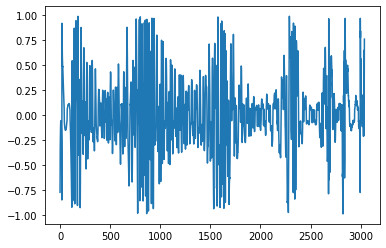

In [97]:
plt.plot(x)

# 50 ms row -> 10 frames

In [6]:
FRAME_SIZE = 346
SR = 22050
HOP_LENGTH = 84

In [5]:
FRAME_SIZE = 512
SR = 22050
HOP_LENGTH = 118

In [6]:
Snd.shape

(10, 13, 1102)

In [12]:
Specs = np.empty((0, 257*6))
for syl in Snd:
    for row in syl:
        x = np.abs(librosa.stft(row, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, center=False)).reshape(1, -1)
        Specs = np.append(Specs, x, axis=0)
Specs = np.append(Specs, np.zeros((2, 257*6)), axis=0)
Specs.shape

(152, 1542)

In [121]:
Specs = np.concatenate((Specs[-1].reshape(1, 13, 1542), Specs[:-1]), axis=0)

In [10]:
Signal = np.empty((0, 1102))
for spec in Specs.reshape(-1, 1542):
    x_ = restore(spec.reshape(257, 6), frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=10)
    Signal = np.append(Signal, x_.reshape(1, -1), axis=0)
x = np.squeeze(Signal.reshape(-1, 1))
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/2.wav', SR, x)

In [13]:
Specs = Specs.reshape(1, -1).reshape(257, -1)

In [15]:
x_ = restore(Specs, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=10)
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/2.wav', SR, x_)

### 10 syllable plots

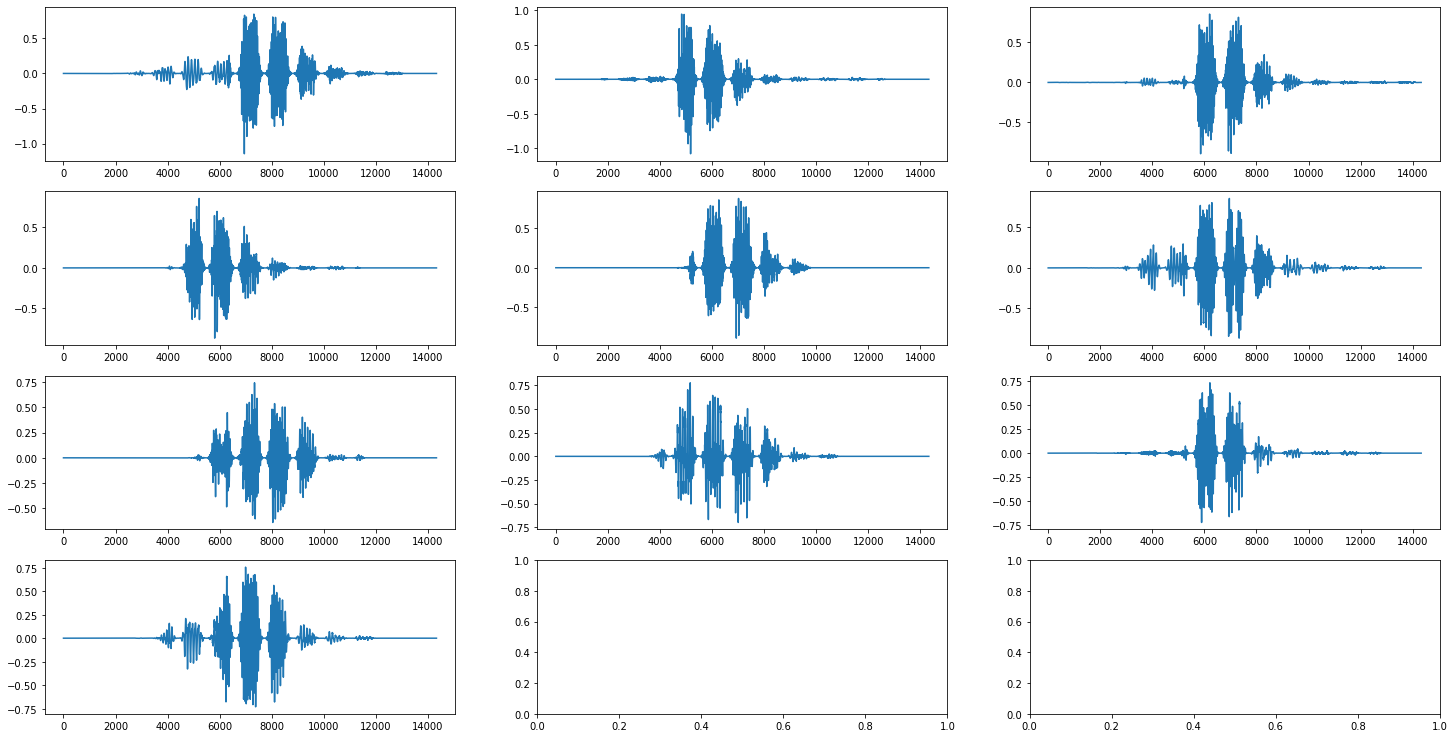

In [124]:
pltSignal = Signal.reshape(10, -1)
fig, axes = plt.subplots(figsize=(25, 13), nrows=4, ncols=3)
for i in range(4):
    for j in range(3):
        axes[i][j].plot(pltSignal[3 * i + j])
        if 3 * i + j == 9:
            break

### 1st syllable (all 13 rows)

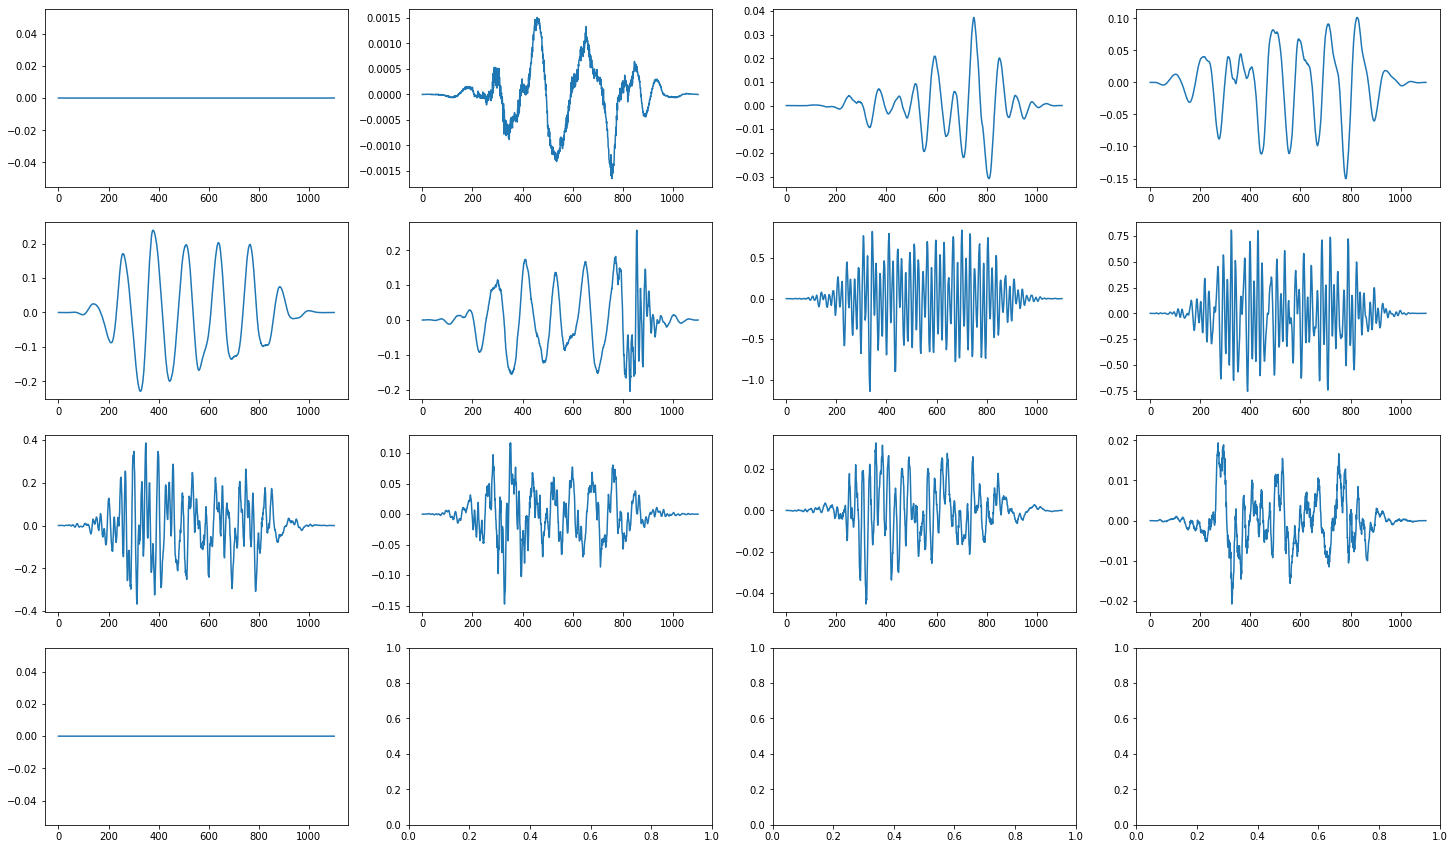

In [125]:
fig, axes = plt.subplots(figsize=(25, 15), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        axes[i][j].plot(Signal[4 * i + j])
        if 4 * i + j == 12:
            break

In [136]:
### Saving filtered file

save = np.empty(0)
for i in range(130):
    save = np.append(save, Signal[i][110:-110], axis=0)
    
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/cut.wav', SR, save)

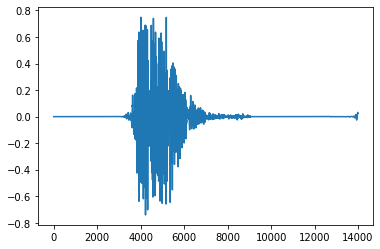

In [137]:
plt.plot(save[:14000])

### csv data research

In [105]:
inds.shape

(3484,)

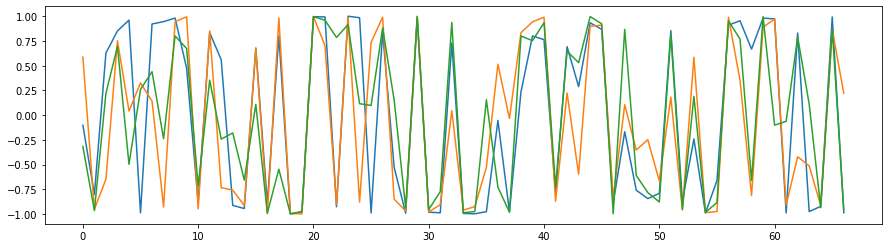

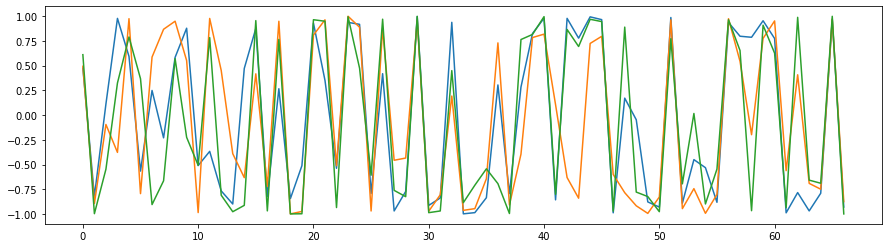

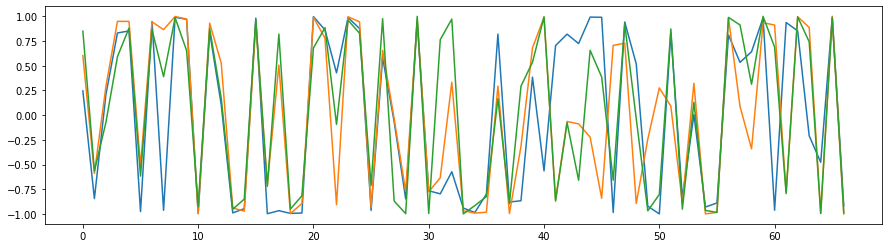

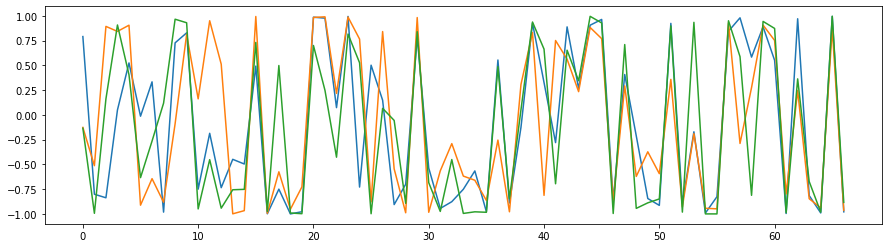

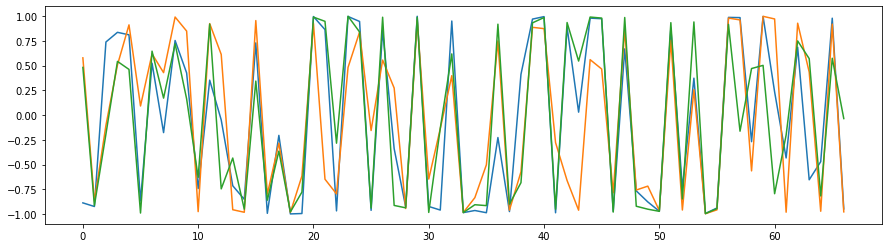

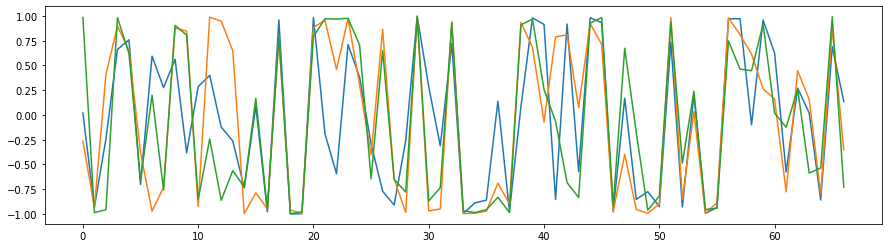

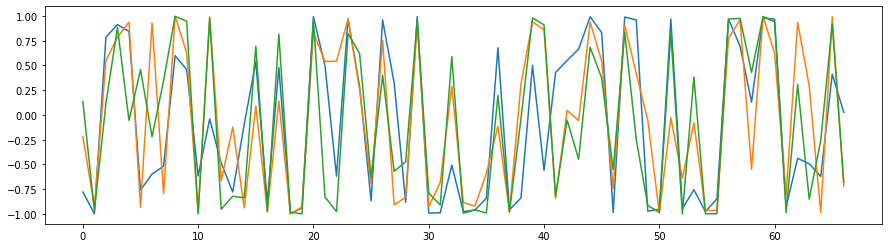

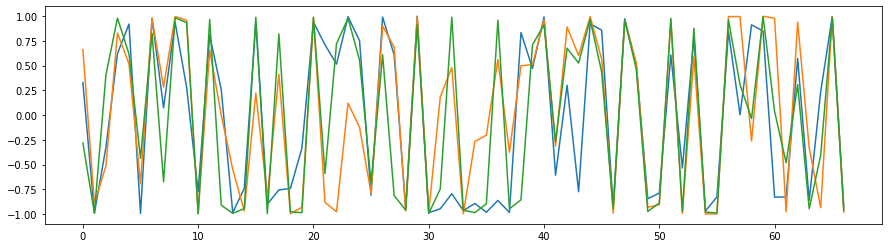

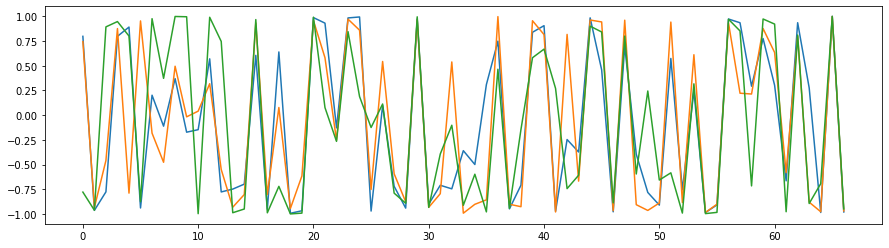

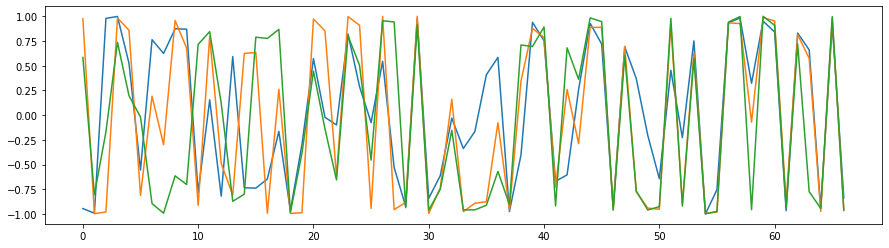

In [122]:
#fig, axes = plt.subplots(figsize=(25, 13), nrows=4, ncols=3)
for i in range(4):
    for j in range(3):
        tmp = inds[label[inds] == 11 + 3 * i + j]
        tmp = np.array(sorted(list(set(tmp).union(*[set(tmp + j) for j in range(1, 13)]))))
        for graph in A[tmp].reshape(-1, 468)[:3, ::7]:
            #axes[i][j].plot(graph)
            plt.plot(graph)
        plt.show()
        if 3 * i + j == 9:
            break
